## Umbral, matriz de confusión y curvas ROC

### 1.1 Determinación del mejor RF con el que trabajaremos

#### Código para importar módulos y leer los datos (todo hasta justo antes de entrenarlo)

In [1]:
# Importamos módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Curva ROC
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.datasets import load_wine

# Cargamos imágenes
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)
    
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]
protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                             
df_protons = df_protons[(df_protons['hillas_intensity']<600)&(df_protons['hillas_length']<6)]
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[df_gamma['hillas_intensity']<600]

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)                                             

label = []                                                                                             
for i in range(3409):
    label.append(1)                                                                   # Nombramos los protones como 1
for j in range(4119):
    label.append(0)                                                                   # Nombramos los gamma como 0
    
df_protongamma.insert(4,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]   

# Ahora ya tenemos los datos procesados para podérselos dar al RF

# Entrenamos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

/tmp/ipykernel_26085/1756142499.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Precisión: 65.5154091392136 %


Vamos a mejorar un poco el modelo para trabajar con el mejor RF que use los parámetros que hemos determinado anteriormente. Una vez obtengamos el mejor RF, empezaremos a estuidar como funciona la matriz de confusión, tratar de determinar la curva ROC para dicho modelo y sacar las distribuciones del clasificador RF.

0.6238044633368757
0.638682252922423
0.6562167906482466
0.6620616365568545
0.6615302869287991
0.6684378320935175
0.6604675876726886
0.6434643995749203
0.6514346439957492
0.6594048884165781
0.6514346439957492
0.6439957492029755
0.6333687566418703
0.6376195536663124
0.6498405951115834
0.6514346439957492
0.6540913921360255
0.6429330499468651
0.6509032943676939
0.6535600425079703

0.6280552603613178
0.6439957492029755
0.6546227417640808
0.6684378320935175
0.6657810839532412
0.6604675876726886
0.675345377258236
0.6578108395324124
0.6493092454835282
0.6599362380446334
0.6530286928799149
0.6535600425079703
0.6599362380446334
0.6450584484590861
0.6503719447396387
0.6493092454835282
0.6530286928799149
0.6434643995749203
0.6524973432518597
0.6482465462274176

0.630712008501594
0.640807651434644
0.6583421891604676
0.6647183846971307
0.6657810839532412
0.6700318809776833
0.667375132837407
0.6530286928799149
0.6509032943676939
0.6620616365568545
0.6604675876726886
0.6503719447396387
0.6535600425079

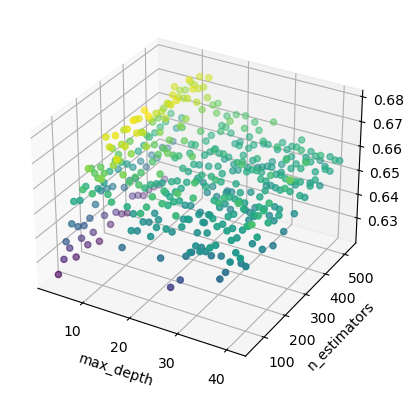

NameError: name 'nest1' is not defined

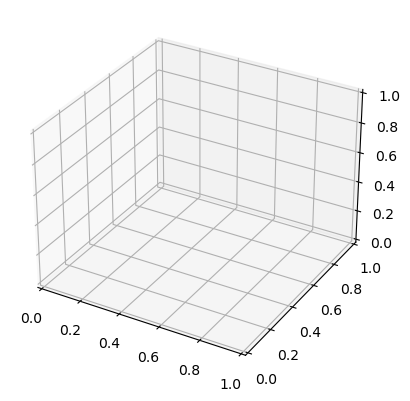

In [4]:
nest = []
maxdep = []
accur = []

n0_estimators = 50
for i in range(20):
    max0_depth = 3
    for j in range(20):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        nest.append(n0_estimators)
        maxdep.append(max0_depth)
        accur.append(accuracy)
        max0_depth = max0_depth + 2
        print(accuracy)
    n0_estimators = n0_estimators + 25
    print()

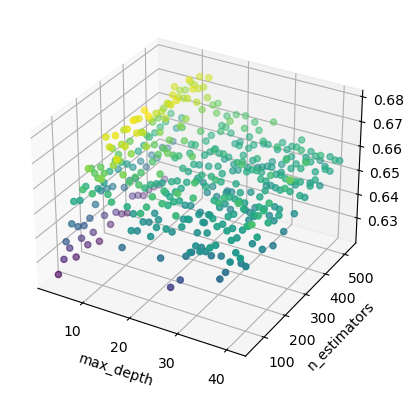

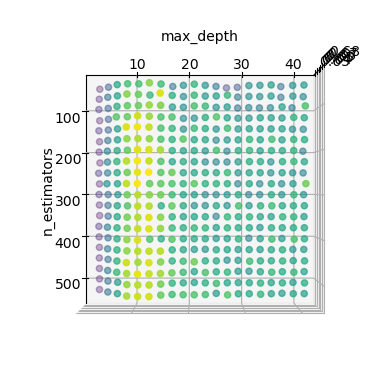

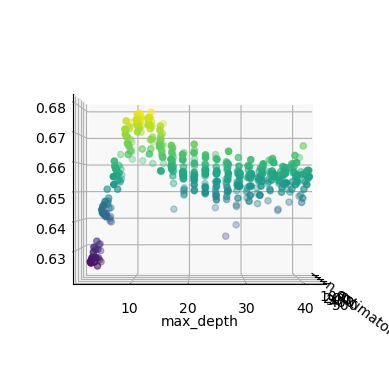

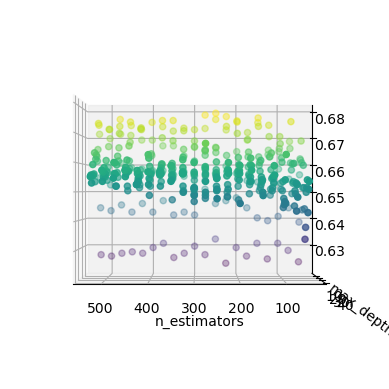

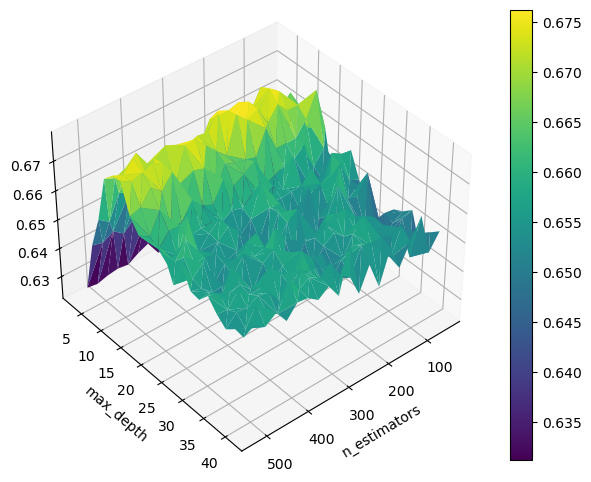

In [12]:
# Representamos los resultados para ver gráficamente la precisión del modelo

ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, accur, c=accur, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nest, maxdep, accur, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(40, 50)
plt.show()

Hay una clara tendencia de donde se encuentra nuestra precisión máxima, siendo ésta prácticamente constante para el número de estimadores (aunque haya cierto máximo entre 200 y 300 (podría deberse a fluctuación debido a la realización de una única estimación)) y encontrándose el máximo entre 9 y 15 decisiones por árbol. Disminuimos las fluctuaciones y nos ponemos de una vez por todas a la matriz y las curvas ROC:

In [14]:
nestF = []
maxdepF = []
accurF = []

n0_estimators = 50
for i in range(20):
    max0_depth = 3
    for j in range(20):
        # RF1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy1 = accuracy_score(y_test, y_pred)

        # RF2
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy2 = accuracy_score(y_test, y_pred)

        # RF3
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy3 = accuracy_score(y_test, y_pred)

        # RF4
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy4 = accuracy_score(y_test, y_pred)

        accuracymean = (accuracy1 + accuracy2 + accuracy3 + accuracy4)/4
        
        nestF.append(n0_estimators)
        maxdepF.append(max0_depth)
        accurF.append(accuracymean)
        
        max0_depth = max0_depth + 2
        print(accuracymean)
    n0_estimators = n0_estimators + 25
    print()

np.savetxt("n_estimatorsF", nestF)
np.savetxt("max_depthF", maxdepF)
np.savetxt("accuracyF", accurF)

0.6238044633368757
0.6354941551540914
0.6505047821466525
0.655951115834219
0.651567481402763
0.6527630180658873
0.6527630180658873
0.6477151965993624
0.6487778958554729
0.6394792773645059
0.6431987247608927
0.644394261424017
0.6442614240170033
0.6453241232731137
0.6499734325185972
0.6410733262486716
0.6424017003188098
0.6327045696068012
0.6467853347502657
0.6483793836344315

0.6280552603613178
0.6400106269925612
0.6558182784272051
0.6482465462274176
0.6578108395324124
0.6478480340063761
0.6583421891604676
0.6526301806588736
0.6493092454835281
0.6526301806588735
0.6498405951115834
0.6519659936238045
0.6445270988310309
0.6401434643995749
0.6389479277364506
0.6499734325185972
0.640807651434644
0.6550212539851222
0.6457226354941552
0.6454569606801275

0.6256641870350691
0.628586609989373
0.6513018065887354
0.6538257173219979
0.6558182784272051
0.6471838469713072
0.6548884165781085
0.6550212539851222
0.6463868225292242
0.6518331562167907
0.6571466524973433
0.6514346439957492
0.6465196599362

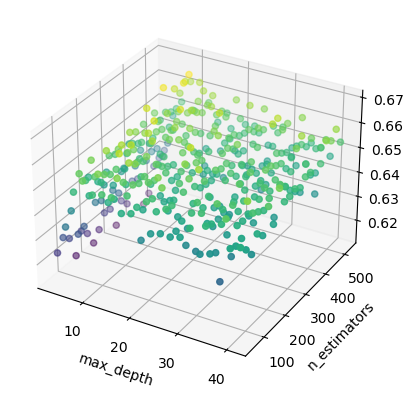

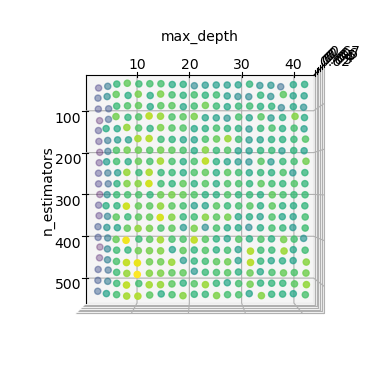

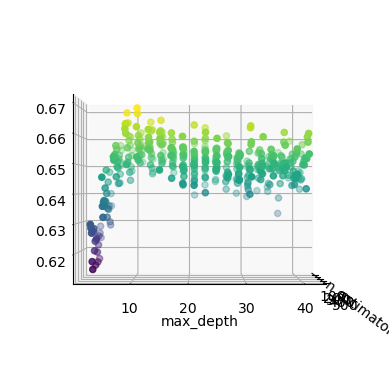

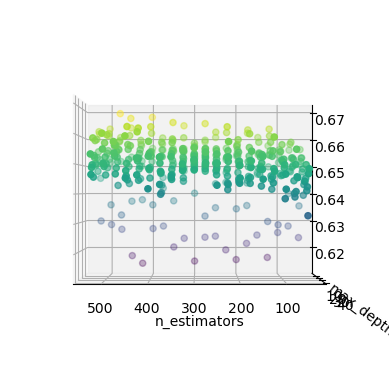

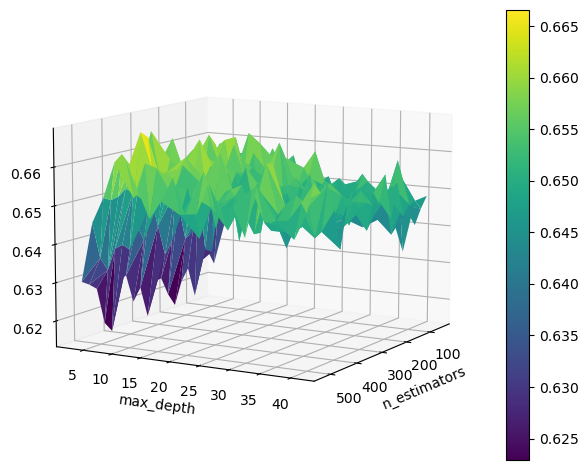

In [21]:
ax = plt.axes(projection='3d') 
ax.scatter(maxdepF, nestF, accurF, c=accurF, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nestF, maxdepF, accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(10, 30)
plt.show()

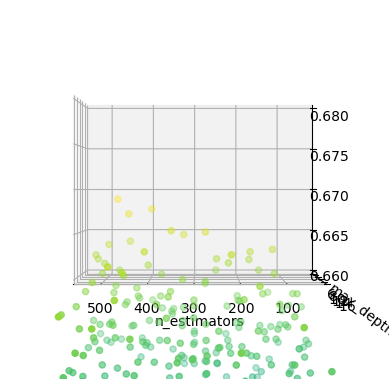

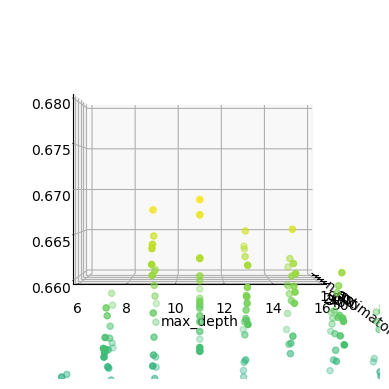

In [43]:
ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap='viridis')
axes = plt.gca()
axes.set_ylim([6, 16])
axes.set_zlim([0.66, 0.68])
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap='viridis')
axes = plt.gca()
axes.set_ylim([6, 16])
axes.set_zlim([0.66, 0.68])
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

#### Sin duda, usando estos parámetros, el mejor RandomForest tiene n_estimators = 400-500 y max_depth = 9-12 y es el que usaremos a partir de ahora:

0.6631243358129649


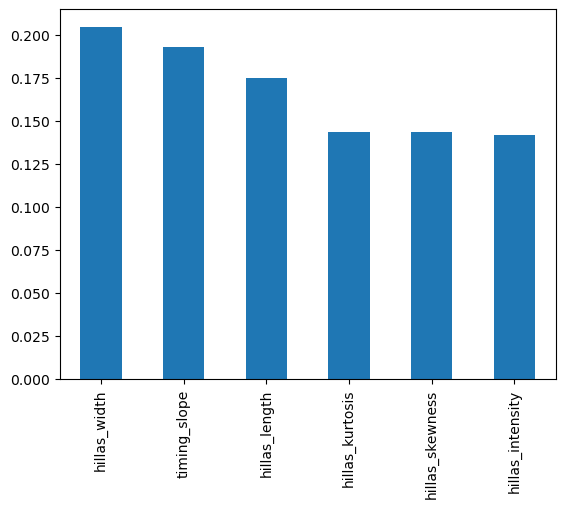

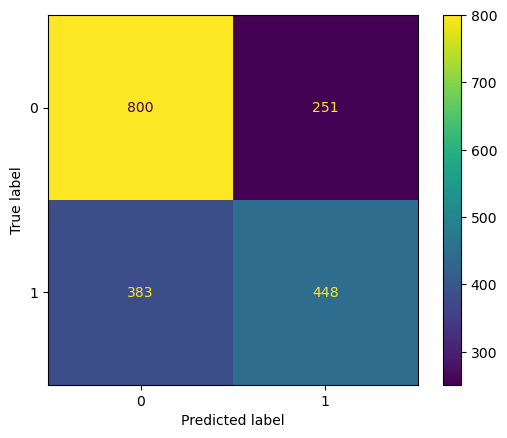

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf = RandomForestClassifier(n_estimators = 450, max_depth = 11)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

Vemos que la precisión en gammas es bastante alta ($\approx$ 80%) y bastante mala para protones ($\approx$ 50%)

### 1.2 Entrenar con más datos

Vamos a cargar nuevos datos para no sobreentrenar el modelo y así que practique con nuevos datos. Cargamos los mismos parámetros y todo igual pero con otro fichero de datos.

(3342, 6)
(4013, 6)
Precisión: 65.74225122349104 %


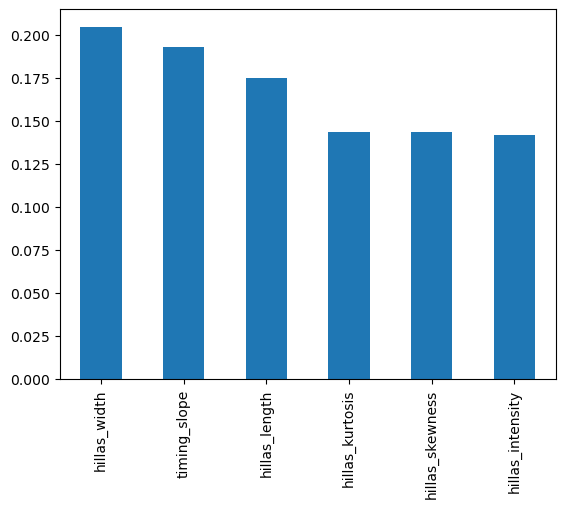

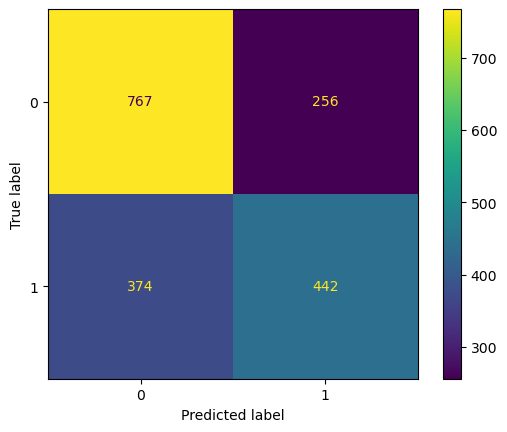

In [70]:
# Cargamos imágenes
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)
    
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]
protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                             
df_protons = df_protons[(df_protons['hillas_intensity']<600)&(df_protons['hillas_length']<6)]
print(df_protons.shape)

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[df_gamma['hillas_intensity']<600]
print(df_gamma.shape)

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)                                             

label = []                                                                                             
for i in range(3342):
    label.append("proton")
for j in range(4013):
    label.append("gamma")
    
df_protongamma.insert(6,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]   

# Ahora ya tenemos los datos procesados para podérselos dar al RF

# Entrenamos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 450, max_depth = 11)
rf_model.fit(X_train, y_train)

# Comprobamos los resultados
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

A priori la precisión de gammas no varía mucho (75%) y la de protones mejora un poco (55%) con este nuevo set de datos.

### 2. Distribución del clasificador

Ahora que hemos obtenido el mejor RF con estos parámetros e hiperparámetros, procedemos al análisis en profundidad de los métodos de evaluación de nuestro modelo para así entender algo mejor cómo funciona el RF y cómo se evalúa.

Los métodos que vamos a entender en esta parte son la matriz de confusión, que ya hemos usado varias veces anteriormente y la curva ROC, que resume muy sencillamente los resultados de nuestro modelo. La pregunta es ¿por qué usar estos métodos y no simplemente como hasta ahora la precisión? Pues no es el caso de nuestra muestra pero si hubiera 1000 datos de los cuales 10 son gammas y 990 son protones, entrenamos nuestro modelo y nos da más del 90% de precisión podría uno pensar que tiene mucha precisión y que es muy bueno, sin embargo, si 99 de cada 100 veces nombrásemos que el suceso es un protón, sin mirar ninguna de sus propiedades y sin tenerlas en cuenta, habríamos creado un modelo con esa misma precisión pero es un modelo completamente inútil ya que no nos da información real, pese a su alta precisión. Es por esto que la matriz de confusión y la curva ROC nos permiten analizar más en profundidad el funcionamiento del modelo.



#### 2.1 Matriz de confusión
La matriz de confusión (para nuestro caso con solo 2 posibles valores, o gammas o protones) está formada por 4 cuadros:
- TP (True Positive): el valor predicho (gamma, 0) se corresponde con el valor real (gamma, 0)
- TN (True Negative): el valor predicho (protón, 1) se corresponde con el valor real (protón, 1)
- FP (False Positive): el valor predicho (gamma, 0) no se corresponde corresponde con el valor real (protón, 1)
- FN (False Negative): el valor predicho (protón, 1) no se corresponde corresponde con el valor real (gamma, 0)

Se muestra gráficamente a continuación:

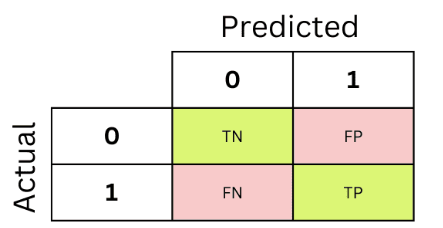

In [3]:
from IPython.display import Image
Image("ConfusionMatrix.png")

#### 2.2 Curva ROC
Una curva ROC (Receiver Operating Characteristic) es una forma gráfica y sencilla de evaluar la calidad de nuestro RandomForest. Un clasificador ideal es aquel que se corresponde con la esquina superior izquierda, es decir, determina todos los sucesos con la respuesta correcta, dando ningún falso positivo. Una línea recta es el que se correspondería con un clasificador aleatorio ya que acertaría el 50% de los sucesos. Un parámetro que resume fácilmente esta evaluación es el área bajo la curva (AUC), siendo 1 para el clasificador ideal y 0.5 para el clasificador aleatorio.

La curva ROC representa el True Positive Rate (de entre todos los casos positivos (protón), cuántos son predichos correctamente, es decir, $TPR = \frac{TP}{TP+FN}$) en función del False Positive Rate (de entre todos los casos negativos (gamma), cuántos son perdichos incorrectamente, es decir, $FPR = \frac{FP}{FP+TN}$). Sin embargo, la curva ROC representa TPR y FPR para varios umbrales, que explicaremos luego en detalle. Si se aumenta el umbral de clasificación, más sucesos se clasifican como negativos, disminuyendo el número de FP y de TP y viceversa.

El umbral más óptimo para nuestro modelo es aquel dond se encuentra el "codo" (dudosa afirmación), es decir, el punto donde la curva pasa de tener una pendiente mayor que 1 a menor que 1. En este punto el FPR es mayor que el TPR y por eso se escoge este punto. Probablemente la matiz de confusión establece el umbral para ser representada en este punto, sin embargo, es posible también que escoja 0.5 como el umbral en el que se determina y es uno de los objetivos que trataremos de determinar en la siguiente parte.

#### 2.3 Umbral del clasificador
Nuestro modelo de RF lo que hace es clasificar un suceso entre dos opciones, o gamma o protón. El concepto de umbral sirve para separar los sucesos que se definen como protones y los sucesos que se definen como gamma de tal forma que el umbral separa las dos clases determinando un valor de probabilidad por encima del cual el suceso se define como positivo (protón) y por debajo del cual el suceso es negativo (gamma). Además, este umbral se puede determinar después de haber entrenado al modelo y así entender algo mejor cómo funciona por dentro dicho modelo.

**¿Cómo afecta el ajuste del umbral a los resultados?**

Primero deberemos entender tres conceptos usados en este ámbito:
- **Precision:** de entre todos los casos positivos predichos, cuántos son predichos correctamente , es decir, $Precision = \frac{TP}{TP+FP}$.
- **Recall:** de entre todos los casos positivos totales, cuántos son predichos correctamente, es decir, $Recall = \frac{TP}{TP+FN}$.
- **F1 score:** es la media armónica de Recall y Precision. En la práctica, el ajuste del umbral hace que si se aumenta Recall, por ejemplo, Precision disminuye y viceversa. En esencia, el F1 score determina el valor del umbral en el que ambas se maximizan. Se define como: $F1 score = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}} = \frac{TP}{TP + \frac{1}{2}(FP+FN)}$.

Como se puede ver en la imagen, si se aumenta el umbral (threshold) TN y FN aumentan y FP y TP disminuyen lo que hace que los TP sean muy puros ya que hay pocos FP (y muchos FN) por lo que Precision aumenta y Recall disminuye y viceversa, si disminuye el umbral, el número de TN es muy puro ya que hay pocos FN (y muchos FP) por lo que Precision disminuye y Recall aumenta

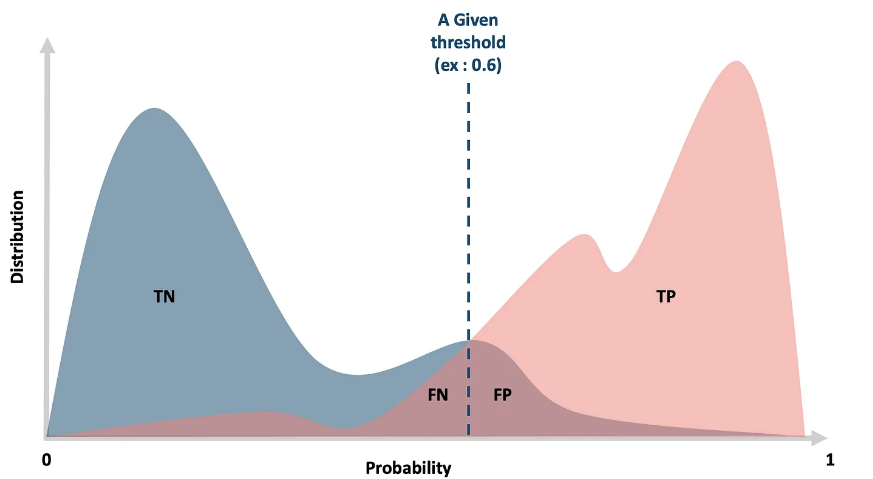

In [37]:
from IPython.display import Image
Image("Threshold.png")

**¿Qué umbral escoger?**

La decisión del umbral que escoger no es trivial en general. La decisión se basa en si apostamos por una mayor precisión (Precision, alto umbral) o por una mayor detección de sucesos (Recall, bajo umbral). Por ello deberemos tener en cuenta dos factores:

- Coste de predicción de FP: cuando el modelo predice un 1 (protón) cuando la etiqueta real es un 0 (gamma). Si lo hace a menudo, deberemos aumentar el umbral ya que hay un alto FP, por tanto una baja Precision, que se compensa con un alto umbral y si no ocurre a menudo, no existe tal riesgo.
- Coste de predicción de FN: cuando el modelo predice un 0 (gamma) cuando la etiqueta real es un 1 (protón). Si lo hace a menudo, deberemos disminuir el umbral ya que hay un alto FN, por tanto una baja Recall, que se comepensa con un bajo umbral y si no ocurre a menudo, no existe tal riesgo.

En nuestros ejemplos de arriba, vemos claramente que nuestro modelo predice un 0 cuando es un 1, es decir, que hay un alto coste de predicción de FN y por lo tanto, esperamos que el umbral más óptimo para nuestro modelo será más bajo que el establecido por la matriz de confusión en el sklearn.

### 3. Distribución del clasificador RF y Matriz de confusión

Vamos ahora que entendemos que la matriz de confusión se define en función del umbral, vamos a calcularla para varios umbrales y ver cómo evalua al modelo de RF:

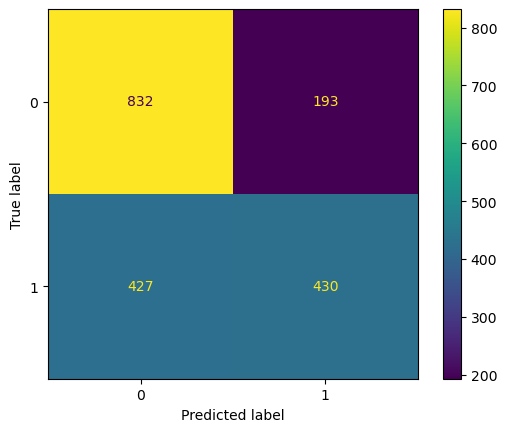

Precisión: 67.05632306057385 %


In [114]:
# Entrenamos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 450, max_depth = 11)
rf_model.fit(X_train, y_train)

# Definimos un umbral de decisión cualquiera para ver el comportamiento de la matriz de confusión
threshold = 0.5

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")                 # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Vemos que la matriz de confusión de sklearn estima en 0.5 dicho umbral

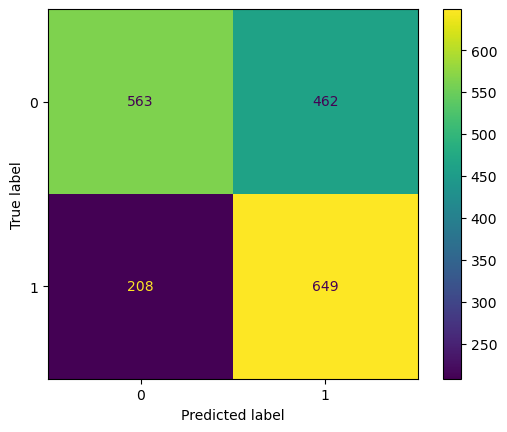

In [115]:
# Definimos un umbral de decisión cualquiera para ver el comportamiento de la matriz de confusión
threshold = 0.4

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")               # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [116]:
# Para esta matriz de confusión mejorada calculamos la precisión de los resultados
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Precisión: 64.39957492029755 %


El siguiente objetivo es estimar qué umbral es el óptimo

Vamos ahora a representar varias matrices de confusión según su umbral y ver cómo, según se aumenta el umbral, TN aumenta, TP disminuye, FN aumenta y FP disminuye.

Precisión: 45.80233793836344 %
Precisión: 58.82040382571733 %
Precisión: 67.05632306057385 %
Precisión: 60.042507970244415 %
Precisión: 54.94155154091393 %


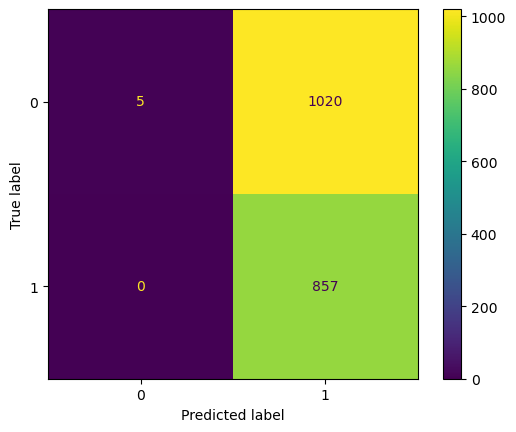

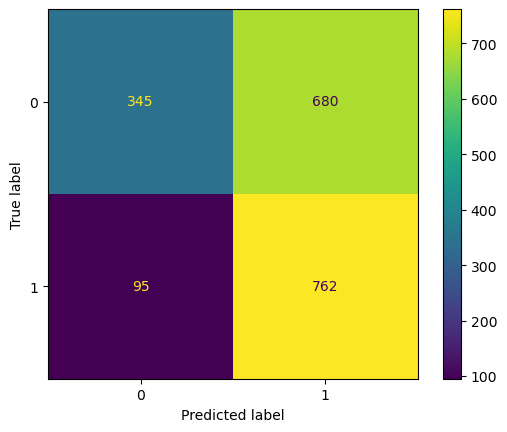

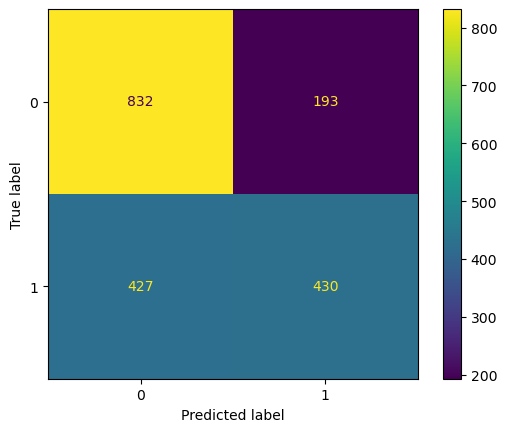

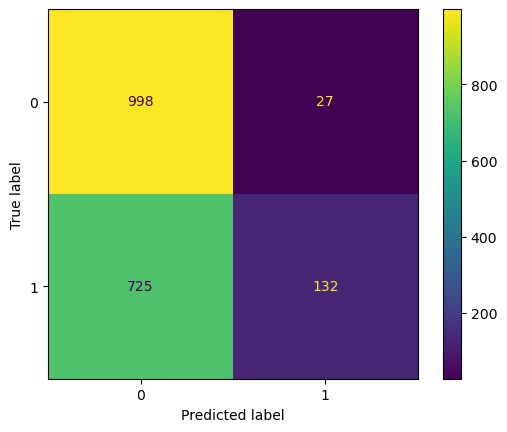

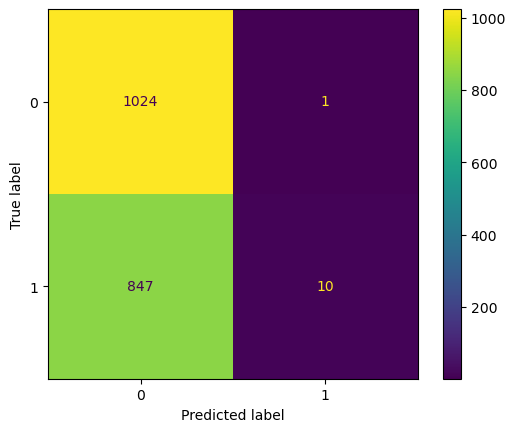

In [117]:
# Comparando los umbrales
thresholds = [0.1,0.3,0.5,0.7,0.9]

for i in range(len(thresholds)):
    threshold=thresholds[i]
    y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    accuracy = accuracy_score(y_test, y_pred)
    print("Precisión:", accuracy*100, "%" )

Vemos claramente el comportamiento esperado, en el que inicialmente solo hay FP y TP y según aumenta el umbral disminuyen a la par que TN y FN aumentan hasta que al final solo quedan TN y FN.

Este comportamiento lo podemos representar en función del umbral para nuestro modelo de tal forma que representamos TN, FN, FP y TP para diferentes umbrales (y ya que estamos la precisión del modelo para cada umbral):

Umbral que maximiza TP y TN: 0.42
Umbral que minimiza FP y FN: 0.45
Umbral que maximiza la precisión: 0.49


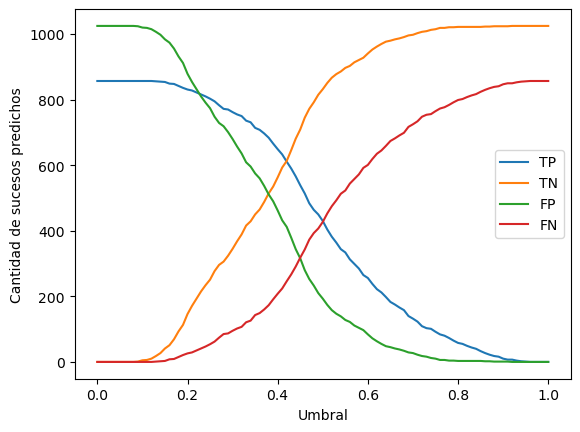

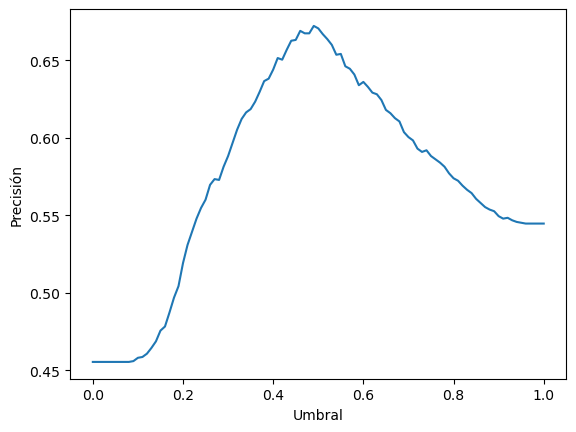

In [118]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
accuracy = []

for threshold in thresholds:
    y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 30:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 30:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)

    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    accuracy.append(accuracyi)

print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)
# Representamos los resultados
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

Vemos que el umbral para el que se maximiza el número de TP y TN es 0.42. Podemos hacer la misma gráfica viendo únicamente los TP y los TN para ver dichos resultados más claramente: 

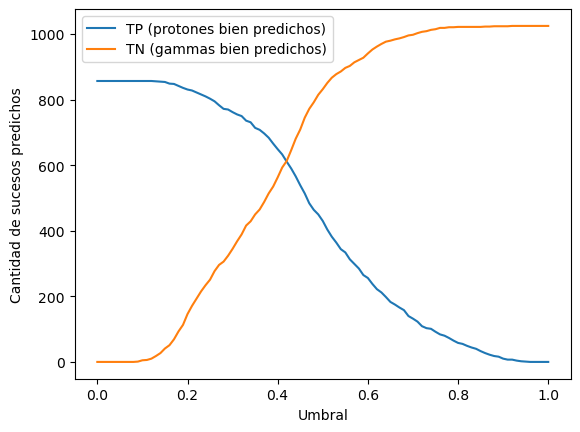

In [119]:
plt.plot(thresholds, TP, label = "TP (protones bien predichos)")
plt.plot(thresholds, TN, label = "TN (gammas bien predichos)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

Calculamos ahora la matriz de confusión con el umbral óptimo y vemos la precisión que nos da:

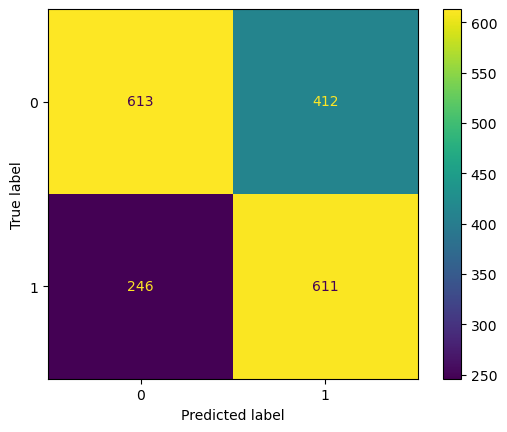

Precisión: 65.03719447396386 %


In [125]:
# Definimosel umbral óptimo:
threshold = 0.42

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")               # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

# Para esta matriz de confusión mejorada calculamos la precisión de los resultados
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Es curioso ver que realmente este umbral no maximiza la precisión del modelo, pero sí que maximiza el TP y el TN. Debemos seguir investigando para saber cuál es el mejor RF posible porque realmente no es el que maximiza TP Y TN sino el que minimiza FP y FN.

Vemos que el umbral para el que se minimiza el número de FP y FN es 0.45. Podemos hacer la misma gráfica viendo únicamente los TP y los TN para ver dichos resultados más claramente: 

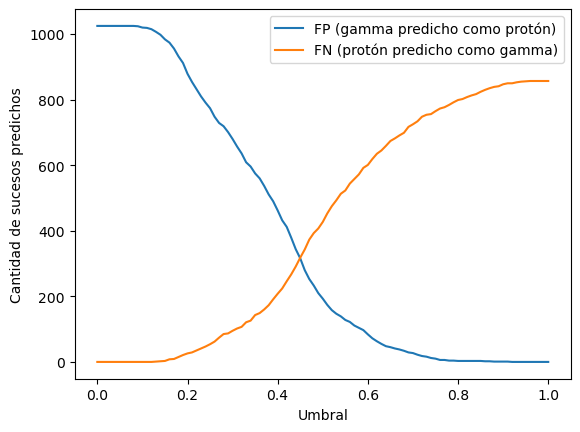

In [121]:
plt.plot(thresholds, FP, label = "FP (gamma predicho como protón)")
plt.plot(thresholds, FN, label = "FN (protón predicho como gamma)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

Calculamos ahora la matriz de confusión con el umbral óptimo y vemos la precisión que nos da:

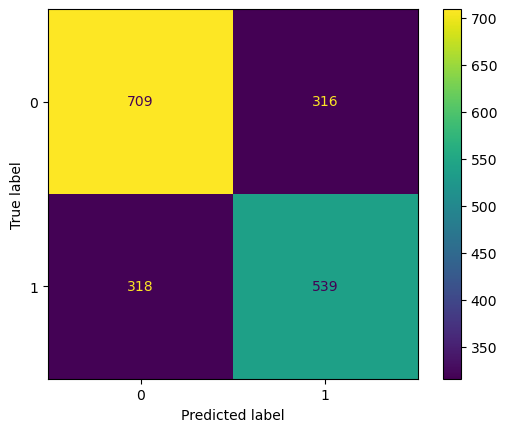

Precisión: 66.31243358129649 %


In [126]:
# Definimos el umbral óptimo:
threshold = 0.45

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")               # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

# Para esta matriz de confusión mejorada calculamos la precisión de los resultados
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

En este caso vemos como la precisión a mejorado con respecto al caso anterior pero no mejora la precisión del modelo con un umbral de 0.5 (LO HE VUELTO A CORRER Y AHORA SÍ PERO NO ES UN RESULTADO GENERAL) lo que significa que aún se puede optimizar el valor del umbral, y no nos podemos quedar con estos casos extremos.

Calculamos la matriz de confusión que maximiza la precisión (con un umbral igual a 0.47):

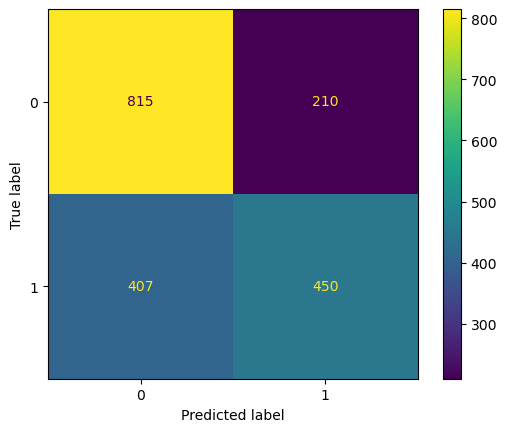

Precisión: 67.21572794899043 %


In [127]:
# Definimos el umbral óptimo:
threshold = 0.49

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")               # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

# Para esta matriz de confusión mejorada calculamos la precisión de los resultados
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

### 4. Curva ROC y AUC

La curva ROC, en esencia muestra cómo de bueno es el modelo clasificando protones y gammas para varios umbrales, no solo uno en específico. Para crear una curva ROC podemos recurrir a la función de sklearn o bien, entendiendo cómo se calcula y aprovechando el código anterior para representar TP, TN, FP y FN en función del umbral representar TPR en función del FPR. Empezamos por la función del sklearn:

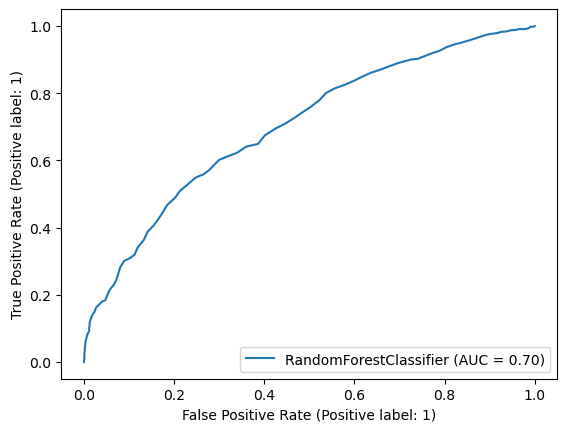

In [6]:
ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax)
plt.show()

Ahora usando el código anterior:

Umbral que maximiza TP y TN: 0.42
Umbral mejor según ROC: 0.44
Umbral mejor según ROC: 0.45
Umbral que minimiza FP y FN: 0.46
Umbral que minimiza FP y FN: 0.47000000000000003
Umbral que maximiza la precisión: 0.53


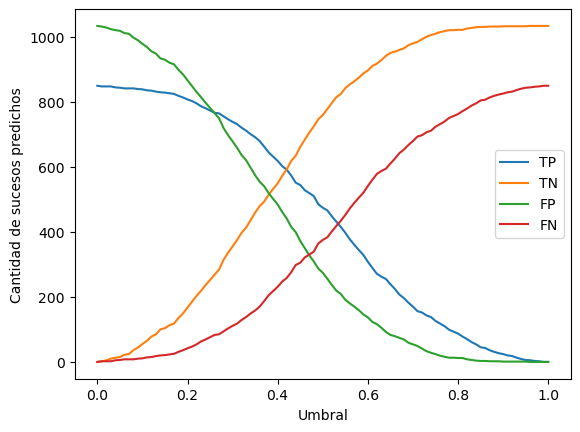

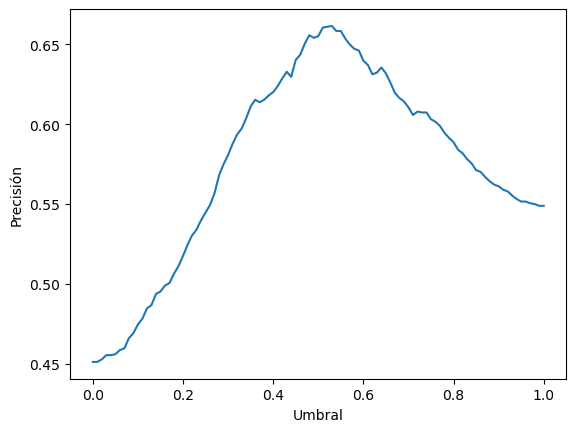

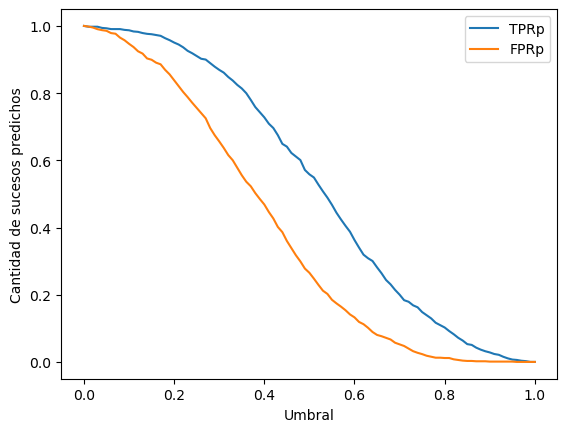

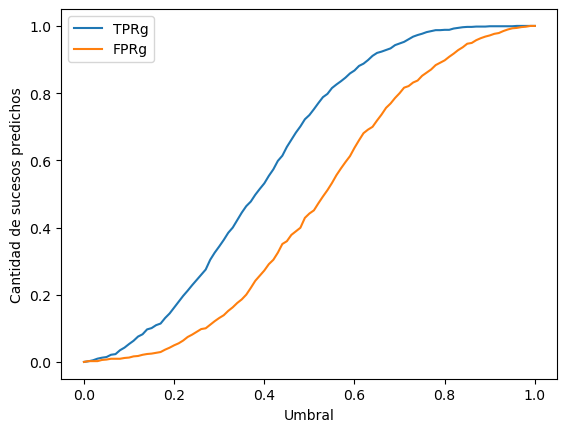

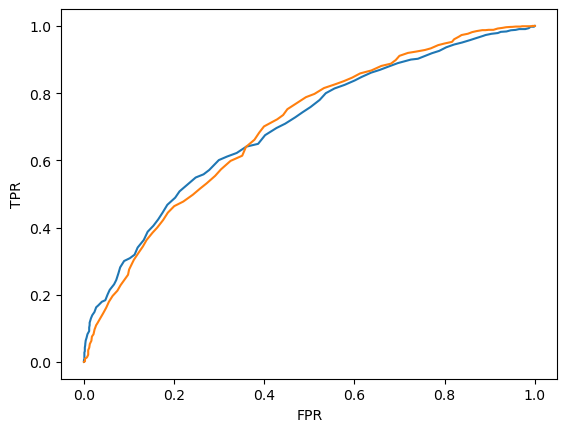

In [10]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
TPRp=[]                                                                       # Para protones
FPRp=[]
TPRg=[]                                                                       # Para gammas
FPRg=[]
accuracy = []

for threshold in thresholds:
    y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    TPRpi=TPi/(TPi+FNi)
    FPRpi=FPi/(FPi+TNi)
    TPRgi=TNi/(TNi+FPi)
    FPRgi=FNi/(FNi+TPi)
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 30:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 30:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)
    elif abs(TPRpi-TPRgi) < 0.05:                                               # Deveulve el umbral para cual la curva ROC se tuerce
        print("Umbral mejor según ROC:", threshold)                         
    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    TPRp.append(TPRpi)
    FPRp.append(FPRpi)
    TPRg.append(TPRgi)
    FPRg.append(FPRgi)
    accuracy.append(accuracyi)

print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)
# Representamos los resultados para TP, FP, TN y FN
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Representamos la precisión
plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

# Representamos los resultados para TPR Y FPR (para protones)
plt.plot(thresholds, TPRp, label = "TPRp")
plt.plot(thresholds, FPRp, label = "FPRp")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Representamos los resultados para TPR Y FPR (para gammas)
plt.plot(thresholds, TPRg, label = "TPRg")
plt.plot(thresholds, FPRg, label = "FPRg")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Representamos la curva ROC (para protones y gammas)
plt.plot(FPRp, TPRp, label = "Protones")
plt.plot(FPRg, TPRg, label = "Gammas")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Vemos que se obtiene el mismo resultado que usando la función del sklearn (representa el caso de protones) y que, como era de esperar, son curvas simétricas.

Es fácil obtener el área bajo la curva de estas curvas ROC (va a ser la misma para los dos casos):

In [13]:
print('AUC para ROC de protones', auc(FPRp,TPRp))
print('AUC para ROC de gammas', auc(FPRg,TPRg))

AUC para ROC de protones 0.7009179981687925
AUC para ROC de gammas 0.7009179981687926


Resultando en el mismo número que nos daba la función de sklearn directamente.

## 5. Resumen

1. Hemos determinado el RF que daba mejores resultados de precisión para los parámetros elegidos según sus hiperparámetros (max_depth: 10-11, n_estimators:  400-500).
2. Hemos entendido los parámetros más importantes a la hora de como se evalúa el RF (al comprobar con X_test y y_test): TP, TN, FP y FN.
3. Hemos determinado la distribución del clasificador para protones y gammas así como la distribución de las falsas etiquetas en función del umbral, o probabilidad de que asigne una etiqueta u otra.
4. A partir de estos resultados hemos obtenido diferentes matrices de confusión según el umbral de probabilidad, viendo cuales maximizaban TP y TN y las que minimizaban FP y FN.
5. Hemos construido un gráfico que nos devuelve la precisión del modelo en función del umbral escogido.
6. A partir de los resultados anteriores hemos obtenido también la curva ROC de nuestro clasificador y el AUC lo que nos da una idea intuitiva de cómo están yendo las cosas

En definitiva, hemos entendido mejor cómo funciona nuestro modelo de RF y de cómo clasifica los resultados, además de que hemos mejorado la precisión del modelo un poco.

Ahora, corremos el código entero (quitando todo lo que sobra) para hacer un resumen y conclusión final.

In [22]:
# Cargamos imágenes
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)
    
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]
protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                             
df_protons = df_protons[(df_protons['hillas_intensity']<600)&(df_protons['hillas_length']<6)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[df_gamma['hillas_intensity']<600]

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)                                             

label = []                                                                                             
for i in range(3342):
    label.append(1)
for j in range(4013):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]   

# Ahora ya tenemos los datos procesados para podérselos dar al RF

# Entrenamos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 450, max_depth = 11)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=450)

Ahora ya está entrenado el modelo del RF, estudiamos los resultados del mismo a partir de los parámetros que hemos analizado:

In [26]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
TPRp=[]                                                                       # Para protones
FPRp=[]
TPRg=[]                                                                       # Para gammas
FPRg=[]
accuracy = []

for threshold in thresholds:
    y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    TPRpi=TPi/(TPi+FNi)
    FPRpi=FPi/(FPi+TNi)
    TPRgi=TNi/(TNi+FPi)
    FPRgi=FNi/(FNi+TPi)
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 30:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 30:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)
    elif abs(TPRpi-TPRgi) < 0.05:                                               # Deveulve el umbral para cual la curva ROC se tuerce
        print("Umbral mejor según ROC:", threshold)                         
    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    TPRp.append(TPRpi)
    FPRp.append(FPRpi)
    TPRg.append(TPRgi)
    FPRg.append(FPRgi)
    accuracy.append(accuracyi)
print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)

Umbral que maximiza TP y TN: 0.43
Umbral mejor según ROC: 0.45
Umbral mejor según ROC: 0.46
Umbral que minimiza FP y FN: 0.47000000000000003
Umbral que maximiza la precisión: 0.51


Representamos TP, TN, FP y FN en función del umbral así como la distribución del clasificador:

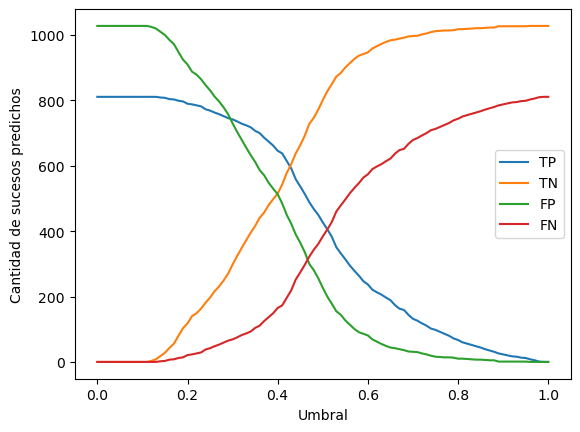

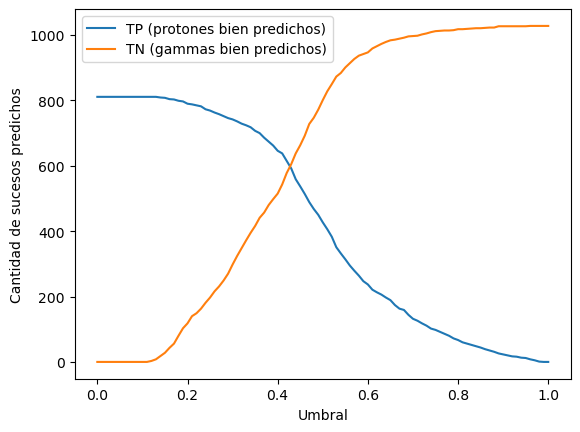

In [24]:
# Representamos los resultados para TP, FP, TN y FN
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Distribución del clasificador RF
plt.plot(thresholds, TP, label = "TP (protones bien predichos)")
plt.plot(thresholds, TN, label = "TN (gammas bien predichos)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

Representamos también la precisión del modelo en función del umbral escogido:

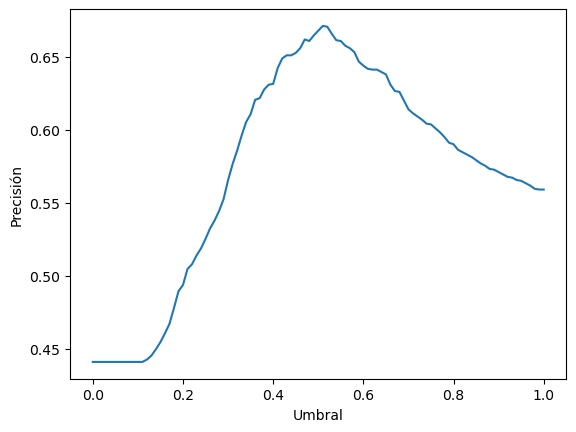

In [25]:
# Representamos la precisión
plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

Calculamos las "mejores" matrices de confusión, es decir, la que maximiza TP y TN y la que minimiza FP y FN:

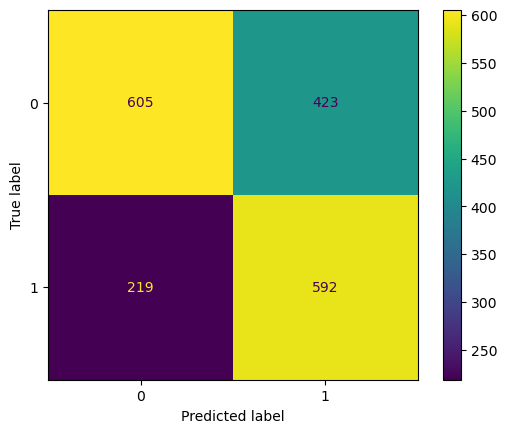

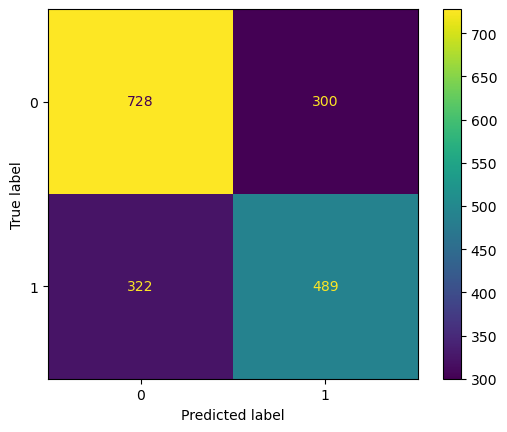

In [27]:
# Definimos el umbral que maximiza TP y TN y el que minimiza FP y FN:
thresholdmax = 0.43
thresholdmin = 0.47

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>thresholdmax).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rf_model.predict_proba(X_test)[:,1]>thresholdmin).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

Finalmente, representamos la curva ROC (para protones y para gammas) y calculamos el AUC:

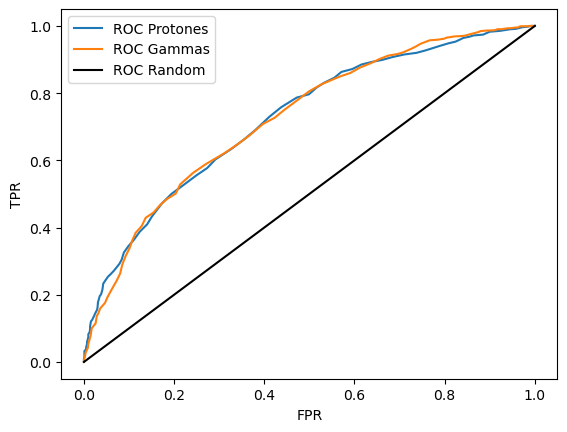

AUC para ROC de protones 0.7247915337264366
AUC para ROC de gammas 0.7247915337264367
AUC para ROC de random 0.5


In [41]:
# Representamos la curva ROC (para protones y gammas)
plt.plot(FPRp, TPRp, label = "ROC Protones")
plt.plot(FPRg, TPRg, label = "ROC Gammas")
ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print('AUC para ROC de protones', auc(FPRp,TPRp))
print('AUC para ROC de gammas', auc(FPRg,TPRg))
print('AUC para ROC de random', 0.5)